In [1]:
%matplotlib inline

## [Feature Pipelines](https://scikit-learn.org/stable/modules/compose.html)
- Pipelines are composite tools. They combine dataset transformers with model builders (classifiers, regressors, ...) The most common type of transformer is a [Feature Union](https://scikit-learn.org/stable/modules/compose.html#feature-union), which combines transformer outputs.
- Pipelines are built with a list of (key,value) pairs. Keys are the name you give to the step; values are estimator objects.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', PCA()), 
              ('clf',        SVC())]
pipe = Pipeline(estimators)
pipe

Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())])

- [make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline) is a "shorthand" utility function.

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
make_pipeline(Binarizer(), MultinomialNB())

Pipeline(steps=[('binarizer', Binarizer()), ('multinomialnb', MultinomialNB())])

- You can retrieve Pipeline properties in various ways.

In [7]:
print(pipe.steps[0], pipe[0], pipe['reduce_dim'])
print(pipe.named_steps.reduce_dim is pipe['reduce_dim'])

('reduce_dim', PCA()) PCA() PCA()
True


In [8]:
print(pipe[:1], pipe[-1:])

Pipeline(steps=[('reduce_dim', PCA())]) Pipeline(steps=[('clf', SVC())])


- You can also retrieve estimator params in various ways. This is particularly import for grid searches.

In [9]:
pipe.set_params(clf__C=10)

Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC(C=10))])

In [10]:
from sklearn.model_selection import GridSearchCV
param_grid = dict(reduce_dim__n_components=[2, 5, 10],
                  clf__C=[0.1, 10, 100])
grid_search = GridSearchCV(pipe, param_grid=param_grid)

- Steps can be replaced; non-final steps can be ignored.

In [11]:
from sklearn.linear_model import LogisticRegression

param_grid = dict(reduce_dim=['passthrough', 
                              PCA(5), 
                              PCA(10)],
                  clf=[SVC(), 
                       LogisticRegression()],
                  clf__C=[0.1, 10, 100])

grid_search = GridSearchCV(
    pipe, 
    param_grid=param_grid)

## [Example: Pipelined Anova SVM](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection_pipeline.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-pipeline-py)

In [12]:
from sklearn                   import svm
from sklearn.datasets          import make_classification
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline          import make_pipeline
from sklearn.model_selection   import train_test_split
from sklearn.metrics           import classification_report

In [13]:
X, y = make_classification(n_features           = 20, 
                           n_informative        = 3, 
                           n_redundant          = 0, 
                           n_classes            = 4,
                           n_clusters_per_class = 2)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# ANOVA SVM-C
# 1) anova filter, take 3 best ranked features
anova_filter = SelectKBest(f_regression, k=3)
# 2) svm
clf = svm.LinearSVC()

anova_svm = make_pipeline(anova_filter, clf)
anova_svm.fit(X_train, y_train)
y_pred = anova_svm.predict(X_test)
print(classification_report(y_test, y_pred))

coef = anova_svm[:-1].inverse_transform(anova_svm['linearsvc'].coef_)
print(coef)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

[[ 0.          0.          0.          0.07063231 -0.25105159  0.
  -0.35149506  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.15418806 -0.70725932  0.
   0.86262154  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.16695494  0.29459743  0.
  -0.51196107  0.          0.          0.        

## [Example: text feature extraction/eval pipeline](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py)
- 20 newsgroups dataset

In [14]:
from pprint import pprint
from time import time
import logging
from sklearn.datasets                import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model            import SGDClassifier
from sklearn.model_selection         import GridSearchCV
from sklearn.pipeline                import Pipeline

In [15]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
]
# Uncomment the following to do the analysis on all the categories
#categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories


In [16]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}


In [17]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")

pprint(parameters)
t0 = time()
grid_search.fit(data.data, data.target)
print("done in %0.3fs" % (time() - t0))

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (20,),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   17.2s finished


done in 18.201s
Best score: 0.951
Best parameters set:
	clf__alpha: 1e-06
	clf__max_iter: 20
	clf__penalty: 'elasticnet'
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)


## [Example: PCA/Logistic Regression Pipeline](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py)
- Uses grid search to set PCA dimensionality

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn                 import datasets
from sklearn.decomposition   import PCA
from sklearn.linear_model    import LogisticRegression
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import GridSearchCV

In [19]:
pca = PCA()
# set tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, 
                              tol=0.1)
pipe = Pipeline(steps=[('pca', pca), 
                       ('logistic', logistic)])

X_digits, y_digits = datasets.load_digits(return_X_y=True)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

Best parameter (CV score=0.920):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 45}


PCA()

/home/bjpcjp/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/bjpcjp/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/bjpcjp/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home/bjpcjp/.local/lib/python3.6/site-packages/pa

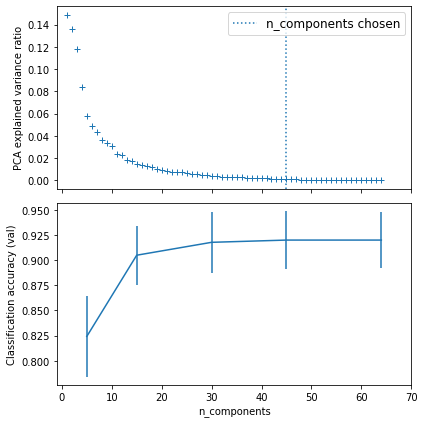

In [20]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))

ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, 
         '+', linewidth=2)

ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', 
            label='n_components chosen')

ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results        = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs      = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 
                         'mean_test_score'))

best_clfs.plot(x=components_col, 
               y='mean_test_score', 
               yerr='std_test_score',
               legend=False, 
               ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

## [Example: Feature map approximation, RBF kernels](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py)

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from time import time
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
from sklearn.decomposition import PCA
digits = datasets.load_digits(n_class=9)

- flatten the image into a matrix of (n_samples, n_features)

In [22]:
n_samples = len(digits.data)
data = digits.data / 16.
data -= data.mean(axis=0)

# We learn the digits on the first half of the digits
data_train, targets_train = (data[:n_samples // 2],
                             digits.target[:n_samples // 2])


# Now predict the value of the digit on the second half:
data_test, targets_test = (data[n_samples // 2:],
                           digits.target[n_samples // 2:])
# data_test = scaler.transform(data_test)

# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=.2)
linear_svm = svm.LinearSVC()

# create pipeline from kernel approximation
# and linear svm
feature_map_fourier = RBFSampler(gamma=.2, random_state=1)
feature_map_nystroem = Nystroem(gamma=.2, random_state=1)
fourier_approx_svm = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", svm.LinearSVC())])

nystroem_approx_svm = pipeline.Pipeline([("feature_map", feature_map_nystroem),
                                        ("svm", svm.LinearSVC())])

# fit and predict using linear and kernel svm:

kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time = time() - linear_svm_time

sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(data_train, targets_train)
    nystroem_times.append(time() - start)

    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    nystroem_score = nystroem_approx_svm.score(data_test, targets_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

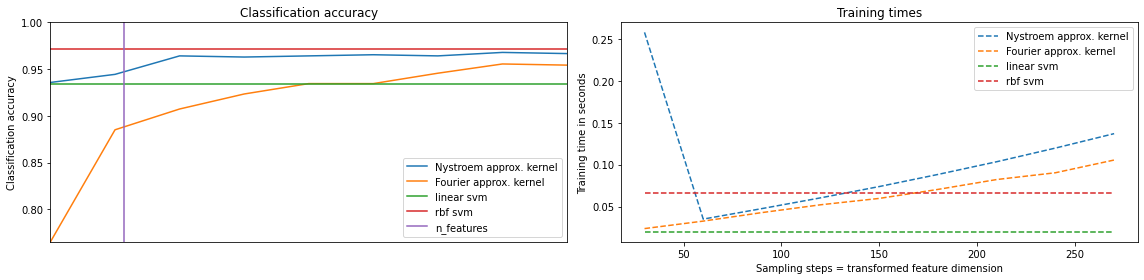

In [23]:
# plot the results:
plt.figure(figsize=(16, 4))
accuracy = plt.subplot(121)
# second y axis for timings
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, '--',
               label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, '--',
               label='Fourier approx. kernel')

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_svm_score, linear_svm_score], label="linear svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_svm_time, linear_svm_time], '--', label='linear svm')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [kernel_svm_score, kernel_svm_score], label="rbf svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [kernel_svm_time, kernel_svm_time], '--', label='rbf svm')

# vertical line for dataset dimensionality = 64
accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc='best')
timescale.legend(loc='best')
plt.tight_layout()
plt.show()

## Transformer Caching
- avoids unnecessary computation using the ```memory``` parameter.

In [24]:
from tempfile              import mkdtemp
from shutil                import rmtree
from sklearn.decomposition import PCA
from sklearn.svm           import SVC
from sklearn.pipeline      import Pipeline

estimators = [('reduce_dim', PCA()), 
              ('clf', SVC())]

cachedir = mkdtemp()
pipe = Pipeline(estimators, memory=cachedir)
print(pipe)
# Clear the cache directory when you don't need it anymore
rmtree(cachedir)

Pipeline(memory='/tmp/tmpsxvf6flc',
         steps=[('reduce_dim', PCA()), ('clf', SVC())])


- Pipelines without caches allow you to inspect the original object:

In [25]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)

pca1 = PCA(); svm1 = SVC()
pipe = Pipeline([('reduce_dim', pca1), 
                 ('clf', svm1)])
pipe.fit(X_digits, y_digits)
print(pca1.components_)

[[-1.77484909e-19 -1.73094651e-02 -2.23428835e-01 ... -8.94184677e-02
  -3.65977111e-02 -1.14684954e-02]
 [ 3.27805401e-18 -1.01064569e-02 -4.90849204e-02 ...  1.76697117e-01
   1.94547053e-02 -6.69693895e-03]
 [-1.68358559e-18  1.83420720e-02  1.26475543e-01 ...  2.32084163e-01
   1.67026563e-01  3.48043832e-02]
 ...
 [ 0.00000000e+00  6.66655322e-17  6.06747010e-18 ... -1.11022302e-16
   1.11022302e-16  6.93889390e-17]
 [ 0.00000000e+00  2.47323788e-16  4.52931343e-17 ...  5.55111512e-17
  -9.02056208e-17  1.94289029e-16]
 [ 1.00000000e+00 -1.68983002e-17  5.73338351e-18 ...  8.66631300e-18
  -1.57615962e-17  4.07058917e-18]]


- Caching causes transformers to be cloned before fitting - so the transformer given to the pipeline can't be directly viewed.

In [26]:
cachedir = mkdtemp()
pca2 = PCA(); svm2 = SVC()
cached_pipe = Pipeline([('reduce_dim', pca2), 
                        ('clf', svm2)],
                       memory=cachedir)
cached_pipe.fit(X_digits, y_digits)

print(cached_pipe.named_steps['reduce_dim'].components_)
rmtree(cachedir)

[[-1.77484909e-19 -1.73094651e-02 -2.23428835e-01 ... -8.94184677e-02
  -3.65977111e-02 -1.14684954e-02]
 [ 3.27805401e-18 -1.01064569e-02 -4.90849204e-02 ...  1.76697117e-01
   1.94547053e-02 -6.69693895e-03]
 [-1.68358559e-18  1.83420720e-02  1.26475543e-01 ...  2.32084163e-01
   1.67026563e-01  3.48043832e-02]
 ...
 [ 0.00000000e+00  6.66655322e-17  6.06747010e-18 ... -1.11022302e-16
   1.11022302e-16  6.93889390e-17]
 [ 0.00000000e+00  2.47323788e-16  4.52931343e-17 ...  5.55111512e-17
  -9.02056208e-17  1.94289029e-16]
 [ 1.00000000e+00 -1.68983002e-17  5.73338351e-18 ...  8.66631300e-18
  -1.57615962e-17  4.07058917e-18]]


## [Transformers and Regressions](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html#sklearn.compose.TransformedTargetRegressor)
- This function transforms the targets (```y```) before fitting a regression model; the predictions are mapped back to the original space via an inverse transform.

In [27]:
import numpy as np
from sklearn.datasets        import load_boston
from sklearn.compose         import TransformedTargetRegressor
from sklearn.preprocessing   import QuantileTransformer
from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import train_test_split

X, y        = load_boston(return_X_y=True)
transformer = QuantileTransformer(output_distribution='normal')
regressor   = LinearRegression()
regr        = TransformedTargetRegressor(regressor=regressor,
                                         transformer=transformer)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
regr.fit(X_train, y_train)

print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))
raw_target_regr = LinearRegression().fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(raw_target_regr.score(X_test, y_test)))

R2 score: 0.67
R2 score: 0.64


/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2370: UserWarning: n_quantiles (1000) is greater than the total number of samples (379). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


## [Example: Target Transforms in Regressions](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py)
- illustrates the benefit of transforming targets before learning a linear regression model.
- 1st example: synthetic data; 2nd example: Boston housing dataset. 

In [28]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion

In [29]:
# synthetic example
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score

# `normed` is being deprecated in favor of `density` in histograms
if LooseVersion(matplotlib.__version__) >= '2.1':
    density_param = {'density': True}
else:
    density_param = {'normed': True}

In [30]:
# y transform: 1) all target entries are non-negative;
# 2) converted to non-linear via an exponential function
X, y = make_regression(n_samples=10000, noise=100, random_state=0)
y = np.exp((y + abs(y.min())) / 200)
y_trans = np.log1p(y)

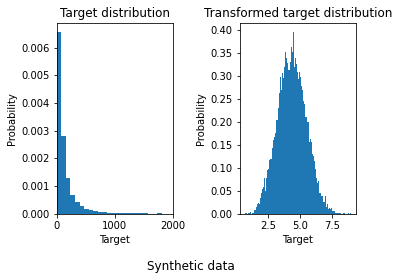

In [31]:
# plot density functions of target before/after the transforms
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, **density_param)
ax0.set_xlim([0, 2000])
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.set_title('Target distribution')

ax1.hist(y_trans, bins=100, **density_param)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed target distribution')

f.suptitle("Synthetic data", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

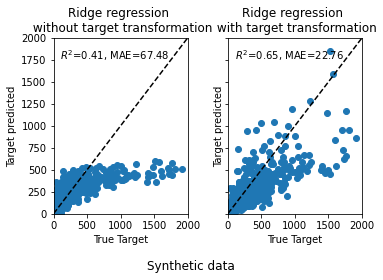

In [34]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

ax0.scatter(y_test, y_pred)
ax0.plot([0, 2000], [0, 2000], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(100, 1750, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax0.set_xlim([0, 2000])
ax0.set_ylim([0, 2000])

regr_trans = TransformedTargetRegressor(regressor=RidgeCV(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)

ax1.scatter(y_test, y_pred)
ax1.plot([0, 2000], [0, 2000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(100, 1750, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax1.set_xlim([0, 2000])
ax1.set_ylim([0, 2000])

f.suptitle("Synthetic data", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

In [35]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import QuantileTransformer, quantile_transform

dataset = load_boston()
target = np.array(dataset.feature_names) == "DIS"
X = dataset.data[:, np.logical_not(target)]
y = dataset.data[:, target].squeeze()
y_trans = quantile_transform(dataset.data[:, target],
                             n_quantiles=300,
                             output_distribution='normal',
                             copy=True).squeeze()

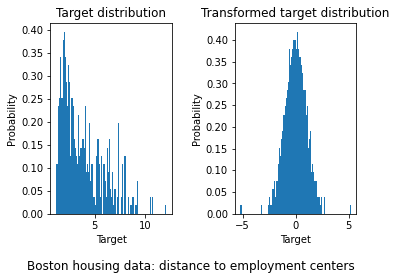

In [36]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, **density_param)
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.set_title('Target distribution')

ax1.hist(y_trans, bins=100, **density_param)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed target distribution')

f.suptitle("Boston housing data: distance to employment centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

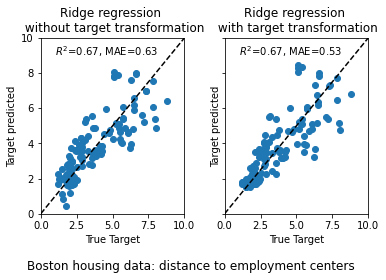

In [37]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

ax0.scatter(y_test, y_pred)
ax0.plot([0, 10], [0, 10], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(1, 9, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax0.set_xlim([0, 10])
ax0.set_ylim([0, 10])

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)

ax1.scatter(y_test, y_pred)
ax1.plot([0, 10], [0, 10], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 9, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax1.set_xlim([0, 10])
ax1.set_ylim([0, 10])

f.suptitle("Boston housing data: distance to employment centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()